In [89]:
import pandas as pd
import numpy as np

import riskfolio as rp

import datetime as dt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# import the path
import os
path = os.path.abspath(os.path.join("..", "08_portfolio_management", "portfolio_data.csv"))

# read the CSV file
df = pd.read_csv(path)

# drop Position_Weight
df = df.drop(columns=['Position_Weight'])

# show the first few rows of the dataframe
df.head()

,Ticker,Last_Price,Quantity,Position_Value
0,AAPL,232.560,18.00,4186.080
1,AMD,168.580,18.00,3034.440
2,ASML,654.300,6.00,3925.800
3,BNB,857.400,13.09,11223.366
4,BR50,21.855,213.00,4655.115


In [90]:
# top 10 holdings
top_10 = df.nlargest(10, 'Position_Value')
top_10

,Ticker,Last_Price,Quantity,Position_Value
5,BTC,111968.6300,2.1571,241527.531773
16,META,738.7000,60.0000,44322.000000
8,ETH,4459.3400,4.3100,19219.755400
7,EQQQ,489.6000,39.0000,19094.400000
15,MC,513.1000,22.0000,11288.200000
3,BNB,857.4000,13.0900,11223.366000
12,IWDE,101.5700,96.0000,9750.720000
6,DOGE,0.2153,40270.0000,8670.131000
22,TSLA,345.9800,23.0000,7957.540000
18,NKE,77.9200,79.0000,6155.680000


In [91]:
# to simplify the calculations and data downloads, we will use only top 10 holdings
port_list = top_10.Ticker.to_list()

# some Ticker should be adjusted for the data source
port_list = [ticker.replace("IWDE", "IWDE.MI").replace("EQQQ", "EQQQ.MI").replace("BNB", "BNB-USD").replace("BTC", "BTC-USD").replace("ETH", "ETH-USD").replace("DOGE", "DOGE-USD").replace("MC", "LVMUY") for ticker in port_list]

In [92]:
port_list

['BTC-USD',
 'META',
 'ETH-USD',
 'EQQQ.MI',
 'LVMUY',
 'BNB-USD',
 'IWDE.MI',
 'DOGE-USD',
 'TSLA',
 'NKE']

Risk Parity Portfolio Optimization

In [93]:
start_date = "2020-01-01"
end_date = dt.datetime.now().strftime("%Y-%m-%d")

# df_stocks = yf.download(port_list, start=start_date, end=end_date)

# # download the data to csv
# df_stocks.to_csv("top_10_stocks.csv")

In [94]:
# read the data from csv
df_stocks = pd.read_csv("top_10_stocks.csv", header=[0,1], index_col=0)

# keep only Close prices (level 0 = 'Close')
df_stocks = df_stocks.loc[:, df_stocks.columns.get_level_values(0) == 'Close']

# drop level 0 (keep only ticker names)
df_stocks.columns = df_stocks.columns.droplevel(0)

# replace -USD with "", replace .MI with ""
df_stocks.columns = df_stocks.columns.str.replace('-USD', '', regex=False)
df_stocks.columns = df_stocks.columns.str.replace('.MI', '', regex=False)

# ffill and dropna()
df_stocks = df_stocks.ffill().dropna()

df_stocks.head()

Ticker,BNB,BTC,DOGE,EQQQ,ETH,IWDE,LVMUY,META,NKE,TSLA
Date,,,,,,,,,,
2020-01-02,13.027011,6985.470215,0.002009,187.924530,127.410179,57.299999,85.065201,208.635391,95.368210,28.684000
2020-01-03,13.660452,7344.884277,0.002145,188.373917,134.171707,57.160000,84.307289,207.531448,95.106918,29.534000
2020-01-04,13.891512,7410.656738,0.002241,188.373917,135.069366,57.160000,84.307289,207.531448,95.106918,29.534000
2020-01-05,14.111019,7411.317383,0.002419,188.373917,136.276779,57.160000,84.307289,207.531448,95.106918,29.534000
2020-01-06,14.957808,7769.219238,0.002463,188.354431,144.304153,57.060001,84.289238,211.440033,95.022911,30.102667


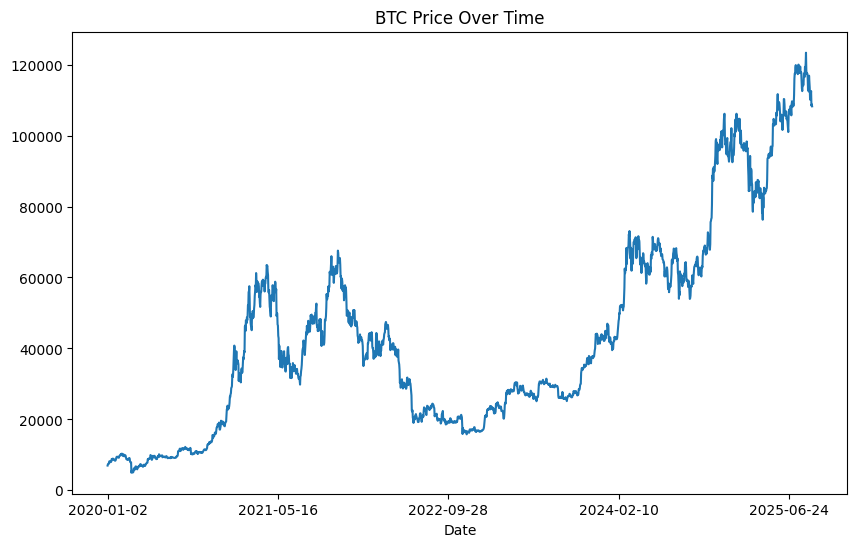

In [95]:
# check data with some plot
df_stocks.BTC.plot(figsize=(10, 6), title='BTC Price Over Time');
# df_stocks.META.plot(figsize=(10, 6), title='META Price Over Time');

In [96]:
prices = df_stocks.copy()
returns = prices.pct_change().dropna()
returns.head()

Ticker,BNB,BTC,DOGE,EQQQ,ETH,IWDE,LVMUY,META,NKE,TSLA
Date,,,,,,,,,,
2020-01-03,0.048625,0.051452,0.067695,0.002391,0.053069,-0.002443,-0.008910,-0.005291,-0.002740,0.029633
2020-01-04,0.016915,0.008955,0.044755,0.000000,0.006690,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,0.015802,0.000089,0.079429,0.000000,0.008939,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.060009,0.048291,0.018189,-0.000103,0.058905,-0.001749,-0.000214,0.018834,-0.000883,0.019255
2020-01-07,0.003439,0.050774,-0.012180,0.010684,-0.005268,0.003680,-0.009420,0.002164,-0.000491,0.038801


This portfolio will be used to perform optimization and calculate the optimal allocation of assets:

In [97]:
port = rp.Portfolio(returns=returns)

"""
hist = Historical data estimates returns, 
while the Ledoit-Wolf method provides a stable covariance matrix.
"""
port.assets_stats(method_mu="hist", method_cov="ledoit")
port.lowerret = 0.00056488 * 1.5

model = "Classic"   # Risk parity optimization with the "Classic" model
rm = "MV"           # Mean-Variance ("MV") risk measure

w_rp = port.rp_optimization(model=model, rm=rm)

In [98]:
# The optimization calculates asset weights to minimize risk and meet return targets.
w_rp

,weights
BNB,0.067094
BTC,0.077755
DOGE,0.040193
EQQQ,0.148538
ETH,0.062780
IWDE,0.153104
LVMUY,0.124242
META,0.113136
NKE,0.125469
TSLA,0.087689


In [99]:
# Create assets list from dataframe columns
assets = df_stocks.columns.tolist()
print("Assets:", assets)

asset_classes = {
    "Assets": assets,
    "Asset_Type": [
        "Crypto",    # BNB
        "Crypto",    # BTC
        "Crypto",    # DOGE
        "ETF",       # EQQQ
        "Crypto",    # ETH
        "ETF",       # IWDE
        "Stocks",    # LVMUY
        "Stocks",    # META
        "Stocks",    # NKE
        "Stocks"     # TSLA
    ],
    "Industry": [
        "Crypto",                  # BNB
        "Crypto",                  # BTC
        "Crypto",                  # DOGE
        "Indexes",                 # EQQQ
        "Crypto",                  # ETH
        "Indexes",                 # IWDE
        "Consumer Discretionary",  # LVMUY
        "Communication Services",  # META
        "Consumer Discretionary",  # NKE
        "Consumer Cyclical"        # TSLA
    ]
}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=["Assets"])
asset_classes

Assets: ['BNB', 'BTC', 'DOGE', 'EQQQ', 'ETH', 'IWDE', 'LVMUY', 'META', 'NKE', 'TSLA']


,Assets,Asset_Type,Industry
0,BNB,Crypto,Crypto
1,BTC,Crypto,Crypto
2,DOGE,Crypto,Crypto
3,EQQQ,ETF,Indexes
4,ETH,Crypto,Crypto
5,IWDE,ETF,Indexes
6,LVMUY,Stocks,Consumer Discretionary
7,META,Stocks,Communication Services
8,NKE,Stocks,Consumer Discretionary
9,TSLA,Stocks,Consumer Cyclical


In [100]:
constraints = {
    "Disabled": [False, False, False, False, False, False, False],
    "Type": ["All Assets", "Classes", "Classes", "Classes", "Classes", "Classes", "Classes"],
    "Set": ["", "Asset_Type", "Asset_Type", "Asset_Type", "Industry", "Industry", "Industry"],
    "Position": ["", "Crypto", "ETF", "Stocks", "Crypto", "Communication Services", "Consumer Discretionary"],
    "Sign": ["<=", "<=", "<=", "<=", "<=", "<=", "<="],
    "Weight": [0.15, 0.4, 0.3, 0.6, 0.4, 0.2, 0.3],
    "Type Relative": ["", "", "", "", "", "", ""],
    "Relative Set": ["", "", "", "", "", "", ""],
    "Relative": ["", "", "", "", "", "", ""],
    "Factor": ["", "", "", "", "", "", ""]
}

"""
added constraints, crypto max 40%, ETF max 30%, Stocks max 60%, 
communication services max 20%, consumer discretionary max 30%

15% is the max weight for any single asset
"""
constraints = pd.DataFrame(constraints)
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,<=,0.15,,,,
1,False,Classes,Asset_Type,Crypto,<=,0.40,,,,
2,False,Classes,Asset_Type,ETF,<=,0.30,,,,
3,False,Classes,Asset_Type,Stocks,<=,0.60,,,,
4,False,Classes,Industry,Crypto,<=,0.40,,,,
5,False,Classes,Industry,Communication Services,<=,0.20,,,,
6,False,Classes,Industry,Consumer Discretionary,<=,0.30,,,,


In [101]:
A, B = rp.assets_constraints(constraints, asset_classes)

port.ainequality = A
port.binequality = B

w_rp = port.rp_optimization(model=model, rm=rm)

In [102]:
w_rp

,weights
BNB,0.067263
BTC,0.077979
DOGE,0.040260
EQQQ,0.149278
ETH,0.062930
IWDE,0.150000
LVMUY,0.124764
META,0.113565
NKE,0.125988
TSLA,0.087973


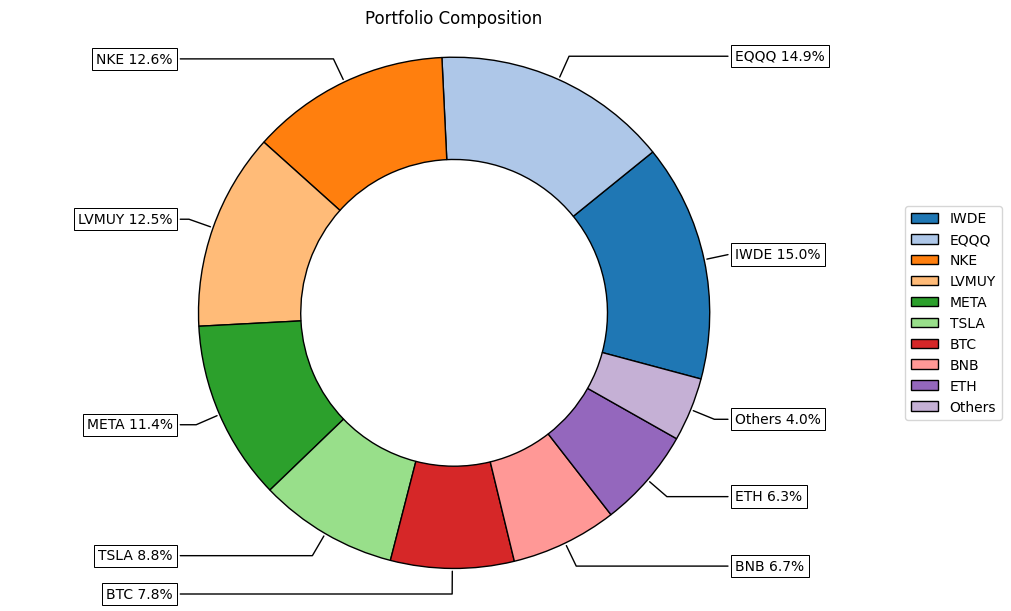

In [103]:
rp.plot_pie(
    w=w_rp, 
    others=0.05,
    nrow=25,
    height=6,
    width=10
);

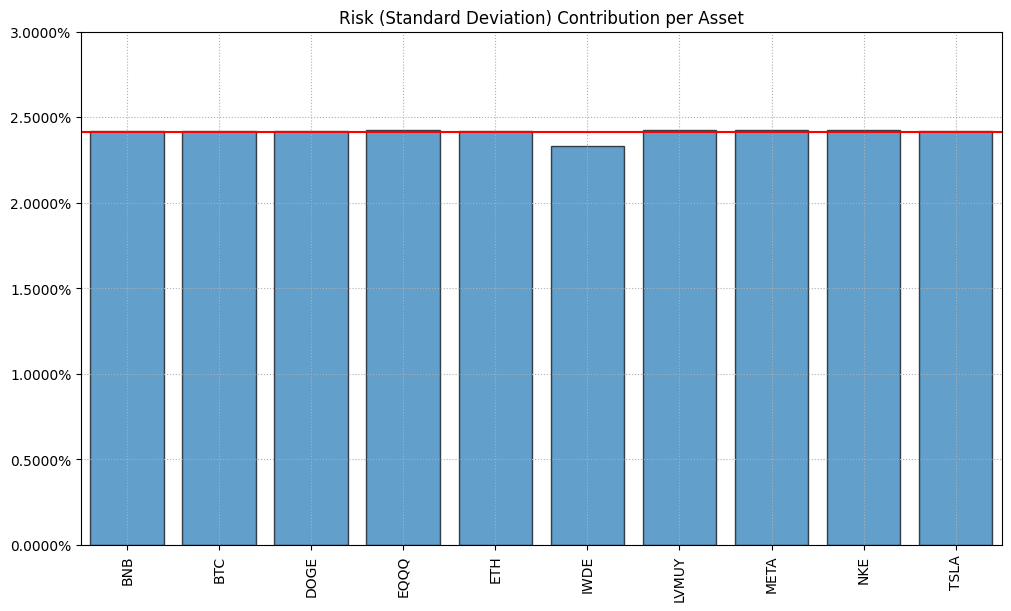

In [104]:
# risk contribution of each asset in the portfolio. 
# This shows how much each asset contributes to the overall portfolio risk
rp.plot_risk_con(
    w_rp, 
    cov=port.cov, 
    returns=port.returns, 
    height=6,
    width=10
);

## Portfolio Optimization Results

The risk parity optimization has successfully allocated weights across our 10-asset portfolio, respecting the defined constraints:

**Key Findings:**
- **Risk Distribution**: The pie chart shows the optimal weight allocation, where each asset contributes proportionally to the portfolio's risk
- **Constraint Compliance**: All constraints are satisfied:
  - Individual assets: ≤15% each
  - Crypto assets: ≤40% total
  - ETFs: ≤30% total
  - Stocks: ≤60% total
  
**Risk Contribution Analysis:**
The risk contribution chart reveals how much each asset contributes to the portfolio's overall risk. In a well-optimized risk parity portfolio, assets with higher individual risk receive lower allocations, while more stable assets can have higher weights.

This approach helps achieve better diversification by balancing risk rather than just capital allocation, potentially leading to more stable returns over time.